## ECS7017P Lab 2

**Complete the exercises in this notebook and submit it as part of Coursework 1.**

# Player Profiling in Dota 2

In this week’s lab you will use this [Jupyter Notebook](https://docs.jupyter.org/en/latest/) to create a set of **player profiles** for the popular MOBA game *Dota 2*. Profiles separate players into groups who are similar in some way. The notebook guides you through this process. However, you will need to make your own decisions and interpret the results as part of the analysis. You are also free to e.g. remove players or adjust features if it helps the profiling, and to add extra visualisations if it helps you understand the data.

A notebook is a series of editable cells, containing either Python code (Code cells) or formatted text (Markdown cells). This notebook was written for [Google Colab](https://colab.research.google.com/) - but it could be run on another cloud service (like [Binder](https://mybinder.org/)) or [locally](https://jupyter.org/install).

### Exercises

The exercises in this lab are assessed, as part of the first coursework in this module. There are 25 marks available.
* Exercise 1: examine correlations between the original features. (2 points)
* Exercise 2: derive some new features to describe players. (3 points)
* Exercise 3: extract new features and reduce the dimensionality of the dataset using PCA. (6 points)
* Exercise 4: use K-Means to look for clusters in the reduced space, and interpret the results as player
profiles. (6 points)
* Exercise 5: consider the cluster tendancy of the dataset. (2 points)
* Exercise 6: apply AHC to the same dataset. (6 points)

### Submitting Your Work

Save/download a copy of this notebook and include that **ipynb file** in your ZIP file submission for Coursework 1.
That file should include all your lab work, i.e. any code/text you've added, and any results and images you generated.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dota 2

In Dota 2, two teams (*Radient* and *Dire*) of five players compete in a match. Each player controls a different *hero*, and fight opposing heroes in player versus player (PvP) combat on a large battlefield. The goal is to destroy the opponent team's *base* and defend yours from the other team. Both teams have weaker NPC members (*creeps*) and defensive buildings which their opponents will try to destroy, e.g. *barracks* (called *rax*) and *towers*. The map also contains neutral NPCs and buildings.

<img src="https://cdn.fastly.steamstatic.com/steam/apps/570/header.jpg" style="margin-left:auto; margin-right:auto"/>

**Experience points (XP)** are gained by killing enemy units, or being nearby as enemy units get killed (an *assist*). It is used to increase a hero's level, increasing their attributes and unlocking new abilities.

**Gold** is earned in various ways, including hero kills/assists, destroying buildings, and *last hitting* enemy creeps (landing the final blow). It is passively gained periodically throughout the game. Gold is used to purchase items, and to bypass the respawn cooldown after death (*buyback*). Players may *deny* opponents gold by killing their own team's creeps.

# The Dataset

The dataset we will be using provides in-game metrics for 865 players. Each player has a unique ID (`PlayerID`) and the following features:

* `GamesPlayed`: number of games the player has played.
* `GamesWon`: number they have won.
* `Ditches`: how many times the player was thrown out of a game.
* `GamesLeft`: how many times they voluntarily left a game early.
* `Points`: experience points gained.
* `Kills`: enemy heroes the player killed.
* `KillsPerMin`: the player’s mean kills per minute played.
* `Deaths`: number of time the player died.
* `Assist`: player is near or damages an enemy hero who’s killed.
* `CreepsKilled`: enemy creep kills.
* `CreepsDenied`: own team's creeps killed.
* `NeutralsKilled`: neutral NPCs killed.
* `TowersDestroyed`: tower buildings destroyed.
* `RaxsDestroyed`: barracks buildings destroyed.
* `TotalTime`: total playtime logged for this player.

# Getting Started

Download the Dota dataset from QMPlus and import it into a Pandas dataframe.

In [2]:
from google.colab import files
uploaded = files.upload()
file_name = "DoTalicious_lab4.csv"
dota = pd.read_csv(file_name)
dota.describe()

Saving DoTalicious_lab4.csv to DoTalicious_lab4.csv


,PlayerID,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
count,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,8.650000e+02
mean,498.176879,88.804624,48.404624,1.604624,0.710983,1014.493444,582.090173,0.131584,526.076301,913.386127,7215.310983,628.055491,1210.575723,67.865896,28.458960,2.236415e+05
std,290.079271,177.433666,100.183653,2.968348,1.810382,119.292057,1281.943028,0.065558,1067.717544,1921.554543,15454.723206,1401.315243,2613.056959,153.569348,64.468938,4.550672e+05
min,0.000000,1.000000,0.000000,0.000000,0.000000,626.837000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.349000e+03
25%,243.000000,3.000000,1.000000,0.000000,0.000000,962.285000,11.000000,0.090000,17.000000,18.000000,160.000000,12.000000,16.000000,1.000000,0.000000,6.240000e+03
50%,500.000000,15.000000,7.000000,0.000000,0.000000,996.646000,74.000000,0.130000,92.000000,123.000000,975.000000,76.000000,145.000000,7.000000,3.000000,3.498000e+04
75%,751.000000,89.000000,47.000000,2.000000,1.000000,1046.430000,511.000000,0.170000,554.000000,862.000000,6621.000000,540.000000,1105.000000,61.000000,26.000000,2.206800e+05
max,1000.000000,1631.000000,852.000000,20.000000,18.000000,2010.240000,11457.000000,0.420000,11220.000000,20133.000000,142043.000000,13030.000000,21770.000000,1501.000000,662.000000,4.294920e+06


PlayerID is a **nominal** variable: these numbers are just names for individual players. The rest of the features are numeric, and will be the basis for our player profiles.

In [3]:
numData = dota.drop(columns='PlayerID') # Ignore player IDs
numFeatures = list(numData.columns.values) # Make a list of numeric features
numFeatures # Show the list

['GamesPlayed',
 'GamesWon',
 'GamesLeft',
 'Ditches',
 'Points',
 'Kills',
 'KillsPerMin',
 'Deaths',
 'Assists',
 'CreepsKilled',
 'CreepsDenied',
 'NeutralsKilled',
 'TowersDestroyed',
 'RaxsDestroyed',
 'TotalTime']

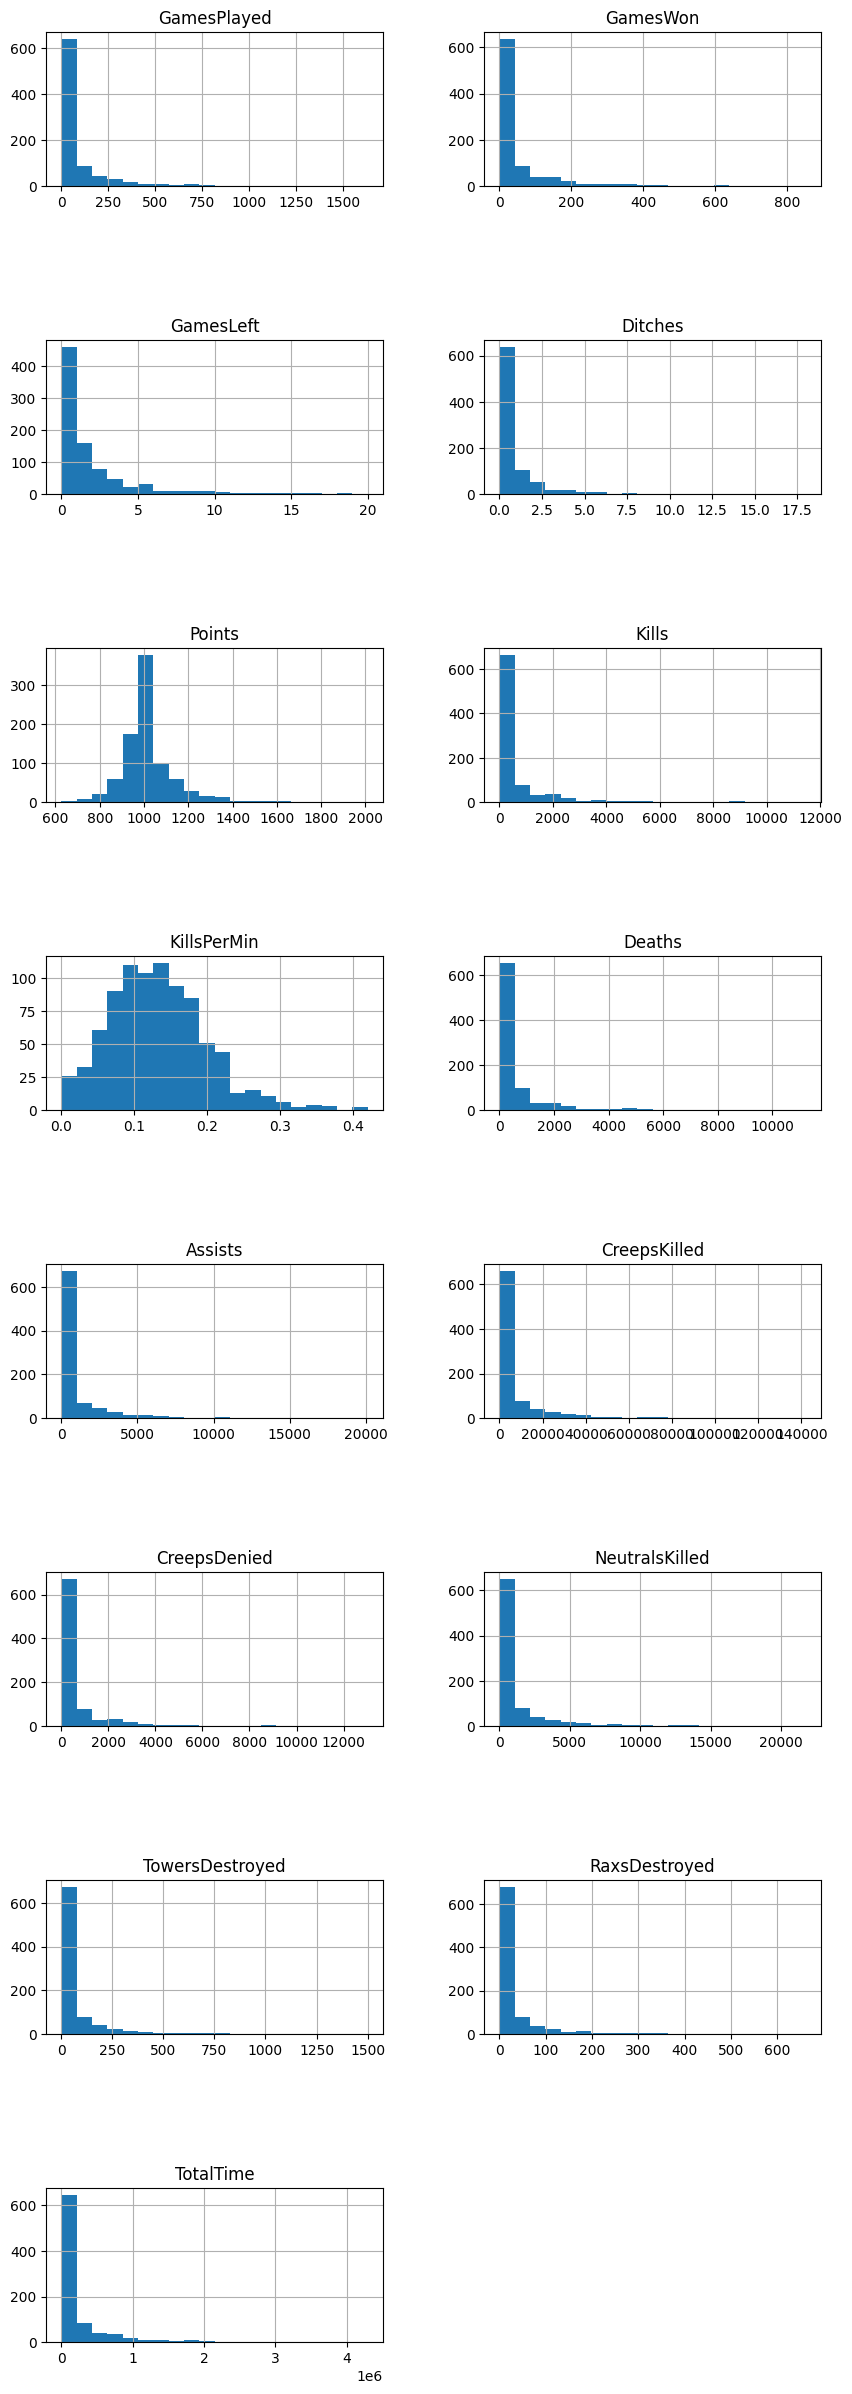

In [4]:
dota[numFeatures].hist(bins=20,figsize=(10,30),layout=(8,2))
plt.subplots_adjust(hspace=1)

# Correlations

Let's see how these features are [correlated](https://www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/statistics/regression-and-correlation/types-of-correlation.html).

In [5]:
# Calculate correlation between each pair of features
correlationMatrix = dota[numFeatures].corr()
# Display correlation matrix
correlationMatrix.style.background_gradient(cmap='Reds')

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
GamesPlayed,1.000000,0.989658,0.633490,0.679918,0.434558,0.952204,0.190443,0.980631,0.991066,0.959716,0.904993,0.944863,0.930926,0.930916,0.999241
GamesWon,0.989658,1.000000,0.631384,0.681182,0.468891,0.975076,0.226965,0.958905,0.988830,0.971850,0.917226,0.936764,0.960305,0.956673,0.986024
GamesLeft,0.633490,0.631384,1.000000,0.557216,0.296151,0.626822,0.231077,0.609055,0.610410,0.618798,0.554171,0.627144,0.611481,0.604425,0.619411
Ditches,0.679918,0.681182,0.557216,1.000000,0.317797,0.651283,0.136975,0.665785,0.670019,0.662770,0.599348,0.672967,0.654895,0.648418,0.673847
Points,0.434558,0.468891,0.296151,0.317797,1.000000,0.477475,0.310594,0.387313,0.446376,0.468354,0.486806,0.393867,0.482782,0.503423,0.433173
Kills,0.952204,0.975076,0.626822,0.651283,0.477475,1.000000,0.278602,0.910421,0.946558,0.983112,0.901193,0.920005,0.984009,0.977834,0.947791
KillsPerMin,0.190443,0.226965,0.231077,0.136975,0.310594,0.278602,1.000000,0.157980,0.191407,0.251990,0.222877,0.208185,0.277149,0.266562,0.183508
Deaths,0.980631,0.958905,0.609055,0.665785,0.387313,0.910421,0.157980,1.000000,0.971094,0.916023,0.852396,0.914816,0.882338,0.874639,0.981946
Assists,0.991066,0.988830,0.610410,0.670019,0.446376,0.946558,0.191407,0.971094,1.000000,0.940424,0.896406,0.919154,0.919779,0.918964,0.989685
CreepsKilled,0.959716,0.971850,0.618798,0.662770,0.468354,0.983112,0.251990,0.916023,0.940424,1.000000,0.925156,0.943714,0.980792,0.975325,0.957503


It seems many of the features are strongly correlated with how many games/playtime was logged. This makes sense: for example, the number of games you win (`GamesWon`) is going to be higher the more games you play (`GamesPlayed`).

---
# Exercise 1

Which feature(s) are not strongly correlated with GamesPlayed? Why do you think this is?

Your answer: ...**KillsPerMin** is not strongly correlated with GamesPlayed, because it has the lowest correlation with GamesPlayed among all features. Besides, players' role in the game can affect the **KillsPerMin** in the game, like supporting players will have low **KillsPerMin** even played lots of games. And **KillsPerMin** is a ratio feature, which means it will not likely to increase as GamesPlayed increases

---

# Feature Engineering


In order to profile players using these in-game metrics, we should focus on how players perform in an *average* game. We want to engineer some new metrics which are independant of how many matches were logged for particular player (`GamesPlayed`), or how much of their playtime was logged overall (`TotalTime`).

For example, we can define a new feature from `WinRate` which measures a player’s wins per game.

array([[<Axes: title={'center': 'WinRate'}>, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

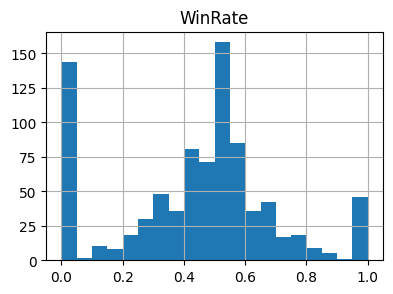

In [6]:
dota['WinRate'] = dota['GamesWon'] / dota['GamesPlayed']

dota[['WinRate']].hist(bins=20,figsize=(10,30),layout=(8,2))

---
# Exercise 2

Following the example of `WinRate`, consider which existing features should be made independent of games played or total playtime. Define these new features. Briefly explain your choice. Plot the distributions for the new features.

Our player profiling will use the new features, and any original features that were already time-independent.

Define list `myFeatures` to include ALL the features you intend to use for player profiling.

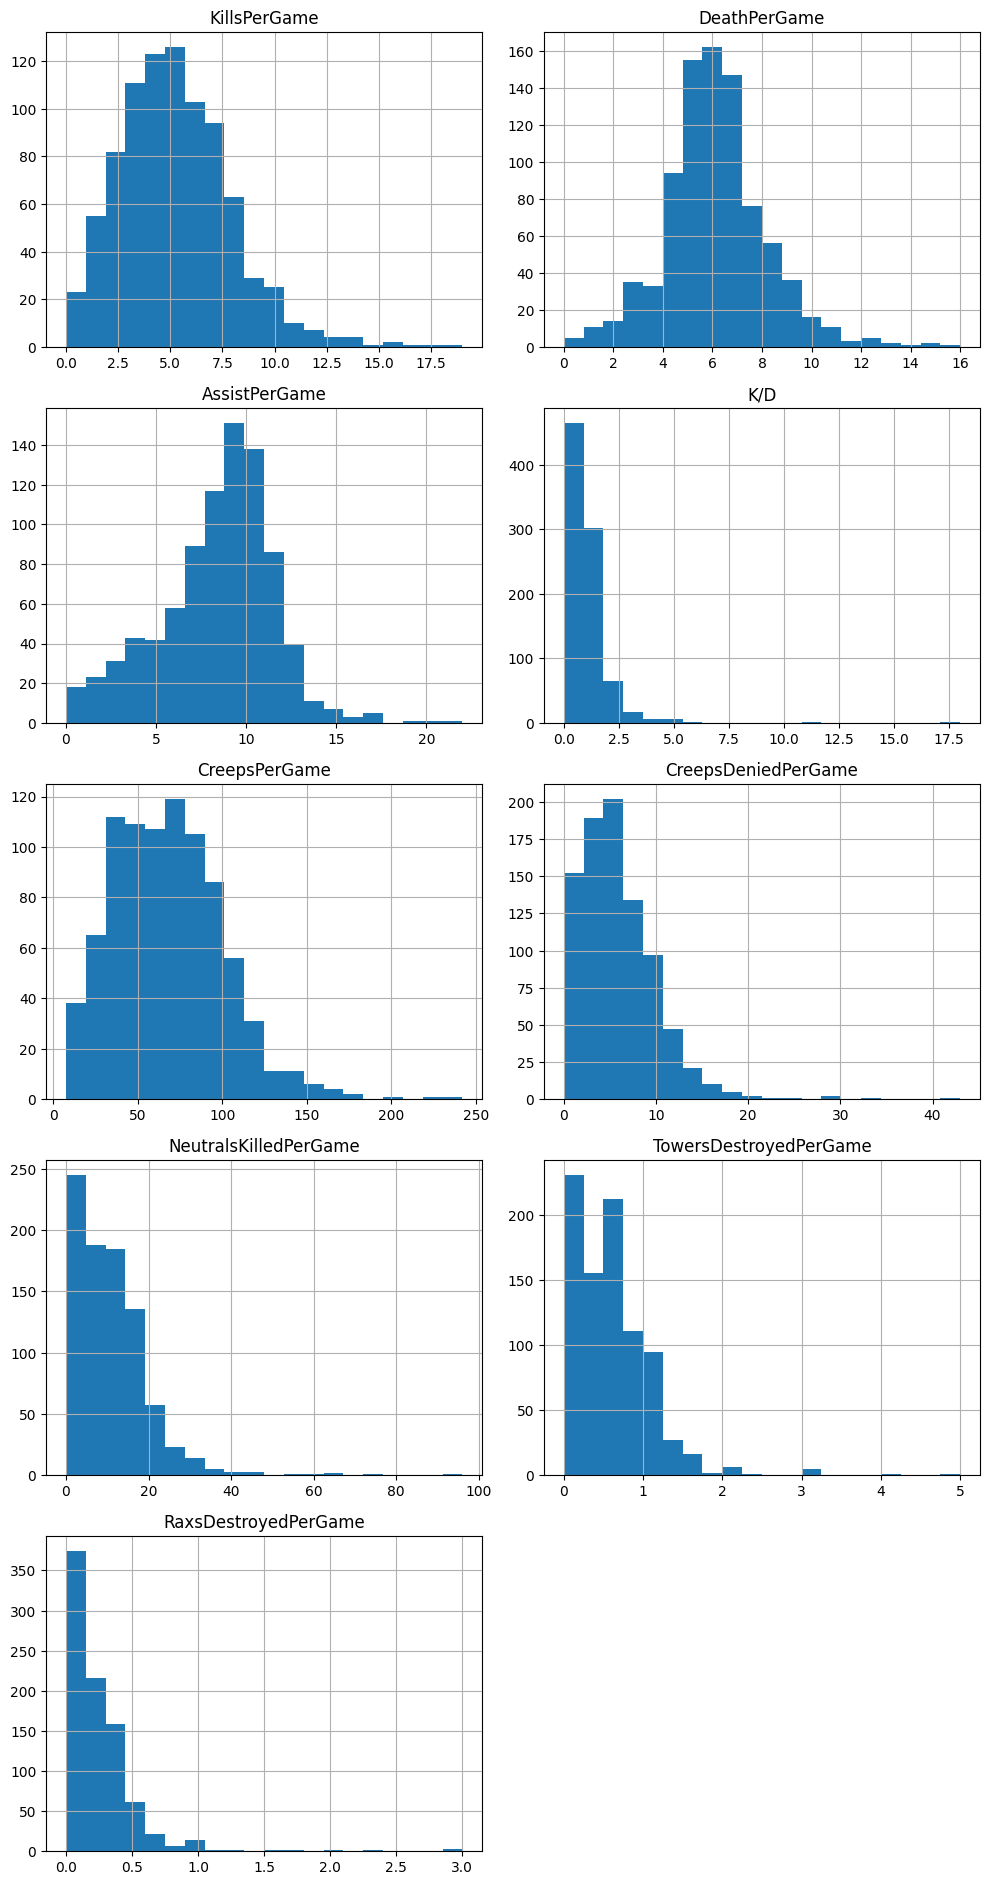

In [7]:
# Add your code
dota['KillsPerGame'] = dota['Kills'] / dota['GamesPlayed']
dota['DeathPerGame'] = dota['Deaths'] / dota['GamesPlayed']
dota['AssistPerGame'] = dota['Assists'] / dota['GamesPlayed']
dota['K/D'] = dota['Kills'] / dota['Deaths'].replace(0, 1)
dota['CreepsPerGame'] = dota['CreepsKilled'] / dota['GamesPlayed']
dota['CreepsDeniedPerGame'] = dota['CreepsDenied'] / dota['GamesPlayed']
dota['NeutralsKilledPerGame'] = dota['NeutralsKilled'] / dota['GamesPlayed']
dota['TowersDestroyedPerGame'] = dota['TowersDestroyed'] / dota['GamesPlayed']
dota['RaxsDestroyedPerGame'] = dota['RaxsDestroyed'] / dota['GamesPlayed']

dota[['KillsPerGame','DeathPerGame','AssistPerGame','K/D','CreepsPerGame','CreepsDeniedPerGame','NeutralsKilledPerGame','TowersDestroyedPerGame','RaxsDestroyedPerGame']].hist(bins=20,figsize=(10,30),layout=(8,2))
plt.tight_layout()
myFeatures = ['WinRate','KillsPerGame','DeathPerGame','AssistPerGame','K/D','CreepsPerGame','CreepsDeniedPerGame','NeutralsKilledPerGame','TowersDestroyedPerGame','RaxsDestroyedPerGame']

Explain your choice: ...

Features like Kills, Deaths can measure players' performance in the game, divide them by GamesPlayed can make them independent of games played

As for new features, AssistPerGame is Assists/GamesPlayed, it can represent an support player's contribution to the team

K/D is Kills/Deaths, which represents a player's combat ability, or surviving skills, it's also independent of games played

---

# Scaling Features

Before we work with the data, we need to scale our selected features.

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Scale our features
dota[myFeatures] = scaler.fit_transform(dota[myFeatures])

# Feature Extraction with PCA

We will now try to **extract** some new features from the data using PCA. Define the variable `nPC` as the
maximum number of principal components to compute. Then apply PCA to the data.

In [9]:
from sklearn.decomposition import PCA
nPC = 5 # Choose a suitable value here
pca = PCA(n_components=nPC).fit(dota[myFeatures]) # Compute PCA
dota_pca = pca.transform(dota[myFeatures]) # Project the player data in the new space

Let's look at the player data plotted against the first two principal components.

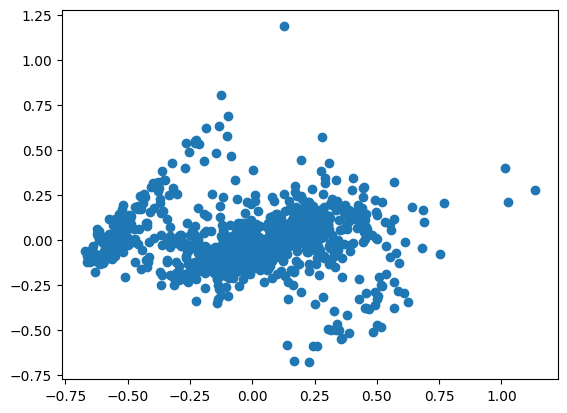

In [10]:
plt.scatter(dota_pca[:,0],dota_pca[:,1])

Examine the proportion of the total variance explained by each of the principal components.

In [11]:
pca.explained_variance_

array([0.09686544, 0.03135059, 0.01913316, 0.00937801, 0.00805935])

Now plot these values for each principal component (PC1, PC2, PC3, ... etc.):

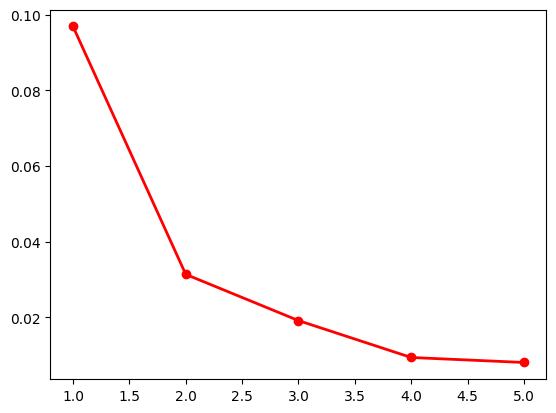

In [12]:
plt.plot(np.arange(pca.n_components_) + 1, pca.explained_variance_, 'ro-', linewidth=2)

Finally, we examine the loadings of your features on the principal components, i.e. the weights used to calculate
each principal component as a linear combination of input features.

In [13]:
pcLabels = ["PC"+str(i) for i in range(1,nPC + 1)]
loadings = pd.DataFrame(pca.components_.T, columns=pcLabels, index=myFeatures)
loadings.style.background_gradient(cmap='bwr',vmin=-1,vmax=1)

,PC1,PC2,PC3,PC4,PC5
WinRate,0.774643,-0.524566,0.028387,0.163835,0.114488
KillsPerGame,0.307037,0.487518,-0.084224,-0.294267,-0.345781
DeathPerGame,-0.146471,0.145139,0.766796,0.354915,-0.039348
AssistPerGame,0.319929,0.095574,0.587308,-0.467422,0.092810
K/D,0.092641,0.068889,-0.181008,-0.171826,-0.146701
CreepsPerGame,0.249386,0.578171,-0.094909,0.159591,0.245457
CreepsDeniedPerGame,0.134853,0.251740,-0.110959,-0.029821,0.654978
NeutralsKilledPerGame,0.107250,0.148688,-0.047649,0.617967,0.004727
TowersDestroyedPerGame,0.205282,0.169482,-0.053280,0.315033,-0.229167
RaxsDestroyedPerGame,0.198100,0.061033,-0.001335,0.071457,-0.542088


---
# Exercise 3

The next step is to drop the less important principal components, retaining those which tell us most about how players vary in their behaviour. Which principal components should we keep, and why? Is there more than one alternative?

Provide an interpretation for each of the components you intend to keep, i.e. how each one describes players.

Your answer:

Keep PC1, PC2, cause variance drops sharply at between PC1 and PC2, it still drops after PC2 but not that steep. Or we can just discard PC5.

PC1 may describes a player's overall performance in the game, a higer PC1 means a player with better skills, having a higer win rate ,contributing to his team through kills and assists
PC2 describes players' resource control ability, mainly through killing creeps and opponents.

---
Define a list `pcs` of the principal components you are keeping. Add each of these as a new column in the dataframe. This is a new lower dimension feature space you can use to analyse player behaviour.

For example, if you only wanted to keep the first two principal components (i.e. reducing the data to two dimensions):

In [14]:
# Edit this with your choice of PCs
pcs = ['PC1','PC2']
dota['PC1'] = dota_pca[:,0]
dota['PC2'] = dota_pca[:,1]

---

# Clustering Players with K-Means

The next stage is to try to cluster players in your lower dimension feature space using K-Means. We will have to decide on the number of clusters `K`.

Let’s define a function `kmeans_eval` to evaluate K-Means clusterings using both WSS and silhouette scores.

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, 10) # Range of K values to examine

# Compute and evaluate K-means clusters for all k_values
def kmeans_eval(some_data):
    wss = []
    silhouettes = []
    for k in k_values:
        model = KMeans(n_clusters=k)
        model.fit(some_data)
        km_labels = model.predict(some_data)
        wss.append(model.inertia_)
        silhouettes.append(silhouette_score(some_data, km_labels))
    return wss, silhouettes

# Apply this to our data
wss, silhouettes = kmeans_eval(dota[pcs])

Plot the WSS for each value of K.

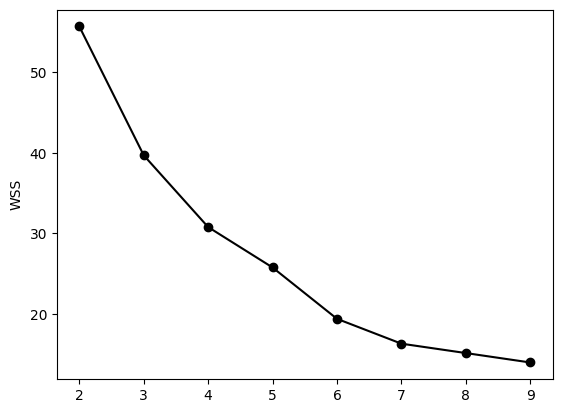

In [16]:
# Plot WSS for each K
plt.plot(k_values, wss, '-o', color='black')
plt.ylabel('WSS')
plt.show()

Repeat this plot for the silhouette widths. Use these plots to decide on a good choice for K. Define this with a variable
`goodK`.

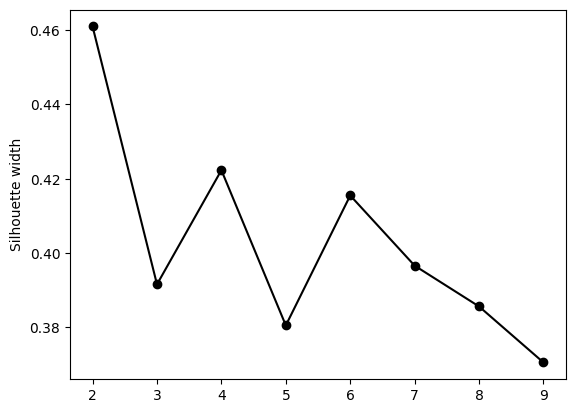

In [17]:
# Plot the silhouette widths for each K
plt.plot(k_values, silhouettes, '-o', color='black')
plt.ylabel('Silhouette width')
plt.show()

In [26]:
goodK = 4

Rerun K-Means with your chosen number of clusters and visualise the results using the first two principal components. You may want to add plots for other PCs.

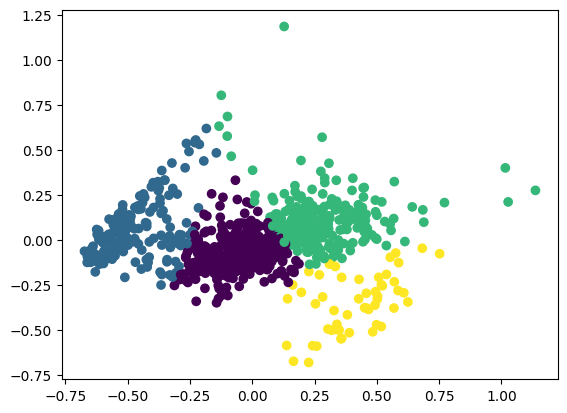

In [27]:
km = KMeans(n_clusters=goodK)
km.fit(dota[pcs])
dota['Cluster1'] = km.predict(dota[pcs])
plt.scatter(dota['PC1'],dota['PC2'],c=dota['Cluster1'])

---
# Exercise 4

Why did you chose this value for K? Interpret the clusters as a set of player profiles. Provide an appropriate **name** and **description** of player behaviour for each profile.

Your answer: ...

goodK=4, firstly, the WSS drops steeply from 2 to 4, then slows down

secondly, Silhouette width gets to a peak at K=4

Berserkers(Green): high PC1 and PC2, combat more and earns more resources

Gankers(Yellow): high PC1 and low PC2, Players who focus more on combat than farming

Farmer(Blue): low PC1 and high PC2, focus more on farming than combat

Balanced Player(Purple): mid PC1 and mid PC2, plays in a balanced style, engage in combats as well as farming




---
# Exercise 5

Do you think the player data has high cluster tendancy? **Justify** your answer using `pyclustertend` package. ([Documentation](https://pyclustertend.readthedocs.io/en/latest/).

Hopkins Statistic: 0.0852


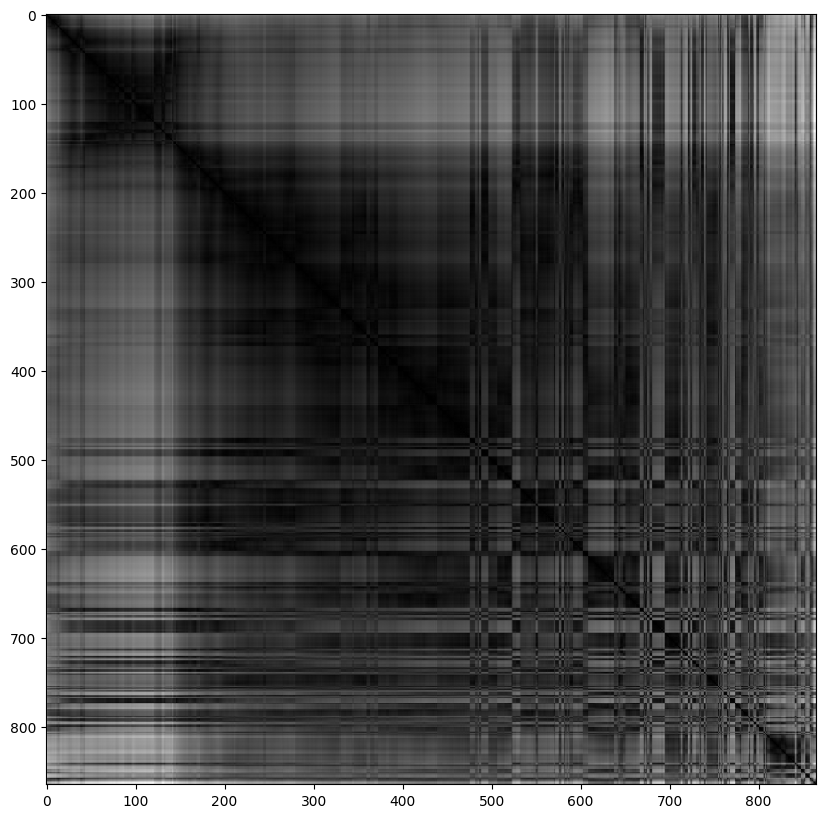

In [28]:
# Your code
!pip install pyclustertend --no-deps

from pyclustertend import hopkins, vat
import numpy as np

data = dota[pcs].values
hopkins_score = hopkins(data, len(data))
vat(data)

print(f"Hopkins Statistic: {hopkins_score:.4f}")

I don't think that the player data has very week cluster tendancy, cause there are barely black rectangles in the VAT graph, and Hopkins Statistic: 0.0852 is quite low

---
# Exercise 6

Read the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) for
Agglomerative Hierarchical Clustering (AHC) and [their example code](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html).

Apply AHC to the Dota dataset and visualise the results as a dendrogram. Provide an interpretation of the results in terms of player behaviour.

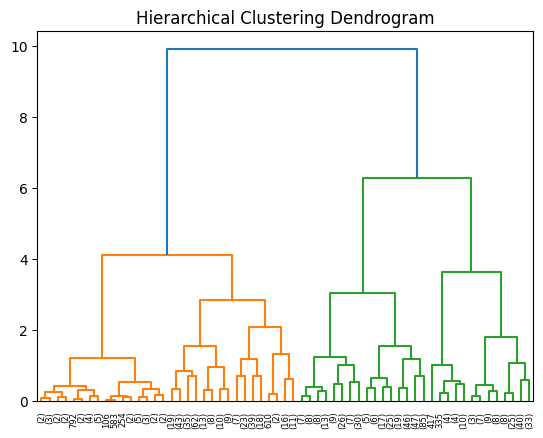

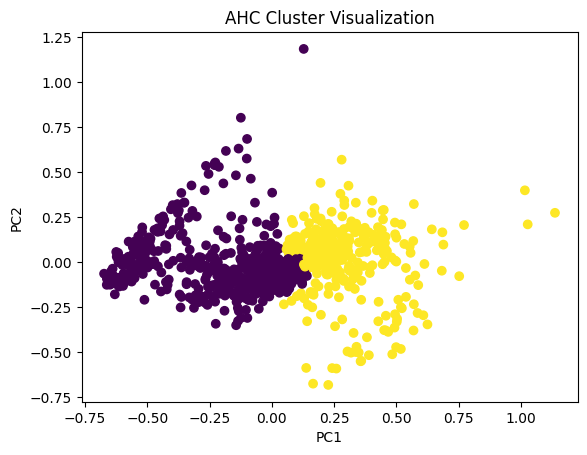

In [35]:
# Your code
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(dota[["PC1", "PC2"]].values)
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=5)
plt.show()

ahc = AgglomerativeClustering(n_clusters=2, linkage="ward")
dota["AHC_Cluster"] = ahc.fit_predict(dota[["PC1", "PC2"]].values)

plt.scatter(dota["PC1"], dota["PC2"], c=dota["AHC_Cluster"])
plt.title("AHC Cluster Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Your answer: ...

Cluster1(purple): players who mainly focus on farming than engaging in battles

Cluster2(Yellow): players who mainly focus on combats and killing rather than economy

# Submission Reminder

Your Coursework 1 ZIP file submission should include a modified copy of this notebook (a .ipynb file) documenting your lab work.